In [23]:
from qdrant_client import QdrantClient, models

try:
    # Initialize the Qdrant client to connect to your local Qdrant server
    client = QdrantClient(host='192.168.4.43', port=6333)
    print("Connected to Qdrant successfully!")
except Exception as e:
    print(f"Failed to connect to Qdrant: {e}")


Connected to Qdrant successfully!


In [3]:
from qdrant_client import QdrantClient


client = QdrantClient(host='192.168.4.43', port=6333, timeout=30)

# Create a new collection in Qdrant with configurations for both dense and sparse vectors
client.create_collection(
    collection_name="products_collection",
    vectors_config={
        "text-dense": {
            "size": 512,  
            "distance": "Cosine"  
        }
    },
    sparse_vectors_config={
        "text-sparse": {
            "index": {
                "on_disk": True,
                "full_scan_threshold": 5000
            }
        }
    }
)


True

Import Required Libraries

In [17]:
import qdrant_client
from qdrant_client import QdrantClient
from langchain.vectorstores import Qdrant
from qdrant_client.http import models
from sentence_transformers import SentenceTransformer

Download the Sparse Model

In [5]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
#
doc_model_id = "naver/efficient-splade-VI-BT-large-doc"
doc_tokenizer = AutoTokenizer.from_pretrained(doc_model_id)
doc_model = AutoModelForMaskedLM.from_pretrained(doc_model_id)
#
query_model_id = "naver/efficient-splade-VI-BT-large-query"
query_tokenizer = AutoTokenizer.from_pretrained(query_model_id)
query_model = AutoModelForMaskedLM.from_pretrained(query_model_id)

Download the Dense Model

In [6]:
from sentence_transformers import SentenceTransformer
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device : {device}")
# load a CLIP model from huggingface
dense_model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)

print(dense_model)

device : cuda
SentenceTransformer(
  (0): CLIPModel()
)


Load the Dataset

In [7]:
import pandas as pd
import os

metadata_path = 'clean_metadata.csv'
metadata = pd.read_csv(metadata_path)

image_root_path = './Images/'
metadata['image'] = metadata.apply(lambda row: os.path.join(image_root_path, f"{row['id']}.jpg"), axis=1)
metadata['image_exists'] = metadata['image'].apply(os.path.exists)
metadata['articleType'] = metadata['category_name']
metadata['productDisplayName'] = metadata['name']
metadata['simplifiedDisplayName'] = metadata['simplified_name']
metadata['articleType_label'] = pd.factorize(metadata['articleType'])[0]
dataset = metadata[['image', 'id', 'articleType', 'productDisplayName', 'articleType_label', 'simplifiedDisplayName']]
dataset.head()

,image,id,articleType,productDisplayName,articleType_label,simplifiedDisplayName
0,./Images/1.jpg,1,Tools and Hardware,DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw -...,0,DeWalt cordless jigsaw
1,./Images/2.jpg,2,Tools and Hardware,Evolution R210SMS 210mm Electric Single-Bevel ...,0,Evolution SMS electric SingleBevel Sliding Mul...
2,./Images/3.jpg,3,Tools and Hardware,Evolution R255SMS-DB 255mm Electric Double-Bev...,0,Evolution SMSDB electric DoubleBevel Sliding M...
3,./Images/4.jpg,4,Tools and Hardware,Milwaukee M18 BLCS66-401B 190mm 18V 1 x 4.0Ah ...,0,Milwaukee RedLithium Brushless cordless Circul...
4,./Images/5.jpg,5,Tools and Hardware,Bosch GST 18V-Li 18V Li-Ion Coolpack Cordless ...,0,Bosch GST Coolpack cordless jigsaw


In [9]:
filtered_dataset = dataset[metadata['image_exists']]
images = filtered_dataset['image']
product_df = filtered_dataset.drop(columns=['image']).rename(columns={"id": "Pid"})

In [55]:
product_df = product_df.merge(metadata[['id', 'image_url', 'price', 'category_name', 'shop_id', 'page_url']], 
                              left_on='Pid', right_on='id', how='left')

In [58]:
product_df.head()

,Pid,articleType,productDisplayName,articleType_label,simplifiedDisplayName,image_url,price,category_name,shop_id,page_url
0,1,Tools and Hardware,DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw -...,0,DeWalt cordless jigsaw,https://media.screwfix.com/is/image/ae235/6358...,109.99,Tools and Hardware,1,https://www.screwfix.com/p/dewalt-dcs331n-18v-...
1,2,Tools and Hardware,Evolution R210SMS 210mm Electric Single-Bevel ...,0,Evolution SMS electric SingleBevel Sliding Mul...,https://media.screwfix.com/is/image/ae235/2965...,119.99,Tools and Hardware,1,https://www.screwfix.com/p/evolution-r210sms-2...
2,3,Tools and Hardware,Evolution R255SMS-DB 255mm Electric Double-Bev...,0,Evolution SMSDB electric DoubleBevel Sliding M...,https://media.screwfix.com/is/image/ae235/128H...,199.99,Tools and Hardware,1,https://www.screwfix.com/p/evolution-r255sms-d...
3,4,Tools and Hardware,Milwaukee M18 BLCS66-401B 190mm 18V 1 x 4.0Ah ...,0,Milwaukee RedLithium Brushless cordless Circul...,https://media.screwfix.com/is/image/ae235/111H...,219.99,Tools and Hardware,1,https://www.screwfix.com/p/milwaukee-m18-blcs6...
4,5,Tools and Hardware,Bosch GST 18V-Li 18V Li-Ion Coolpack Cordless ...,0,Bosch GST Coolpack cordless jigsaw,https://media.screwfix.com/is/image/ae235/2631...,139.99,Tools and Hardware,1,https://www.screwfix.com/p/bosch-gst-18v-li-18...


In [70]:
from qdrant_client import QdrantClient
from tqdm import tqdm

# Initialize the Qdrant client
client = QdrantClient(host='192.168.4.43', port=6333)
COLLECTION_NAME = 'products_collection'

# Assuming you need to update all rows from the DataFrame
ids = product_df['Pid'].tolist()  # List of point IDs to update
payloads = {}

# Create a dictionary of payloads where keys are point IDs
for index, row in tqdm(product_df.iterrows(), total=product_df.shape[0]):
    payloads[row['Pid']] = {
        "image_url": row['image_url'],
        "price": row['price'],
        "category_name": row['category_name'],
        "shop_id": row['shop_id'],
        "page_url": row['page_url']
    }

# Since set_payload can only set the same payload for multiple points,
# if each point has unique data, we need to loop through each point
for point_id in tqdm(ids):
    if point_id in payloads:
        client.set_payload(
            collection_name=COLLECTION_NAME,
            payload=payloads[point_id],
            points=[point_id],  # Set payload for this single point
        )

print("Payload update operations completed.")


100%|██████████| 64335/64335 [21:27<00:00, 49.98it/s] 

Payload update operations completed.


In [10]:
print(images.head())
print(product_df.head())

0    ./Images/1.jpg
1    ./Images/2.jpg
2    ./Images/3.jpg
3    ./Images/4.jpg
4    ./Images/5.jpg
Name: image, dtype: object
   Pid         articleType                                 productDisplayName  \
0    1  Tools and Hardware  DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw -...   
1    2  Tools and Hardware  Evolution R210SMS 210mm Electric Single-Bevel ...   
2    3  Tools and Hardware  Evolution R255SMS-DB 255mm Electric Double-Bev...   
3    4  Tools and Hardware  Milwaukee M18 BLCS66-401B 190mm 18V 1 x 4.0Ah ...   
4    5  Tools and Hardware  Bosch GST 18V-Li 18V Li-Ion Coolpack Cordless ...   

   articleType_label                              simplifiedDisplayName  
0                  0                             DeWalt cordless jigsaw  
1                  0  Evolution SMS electric SingleBevel Sliding Mul...  
2                  0  Evolution SMSDB electric DoubleBevel Sliding M...  
3                  0  Milwaukee RedLithium Brushless cordless Circul...  
4               

Create Sparse vectors

In [11]:
import torch

def compute_vector(text, tokenizer, sparse_model):
    """
    Computes a vector from logits and attention mask using ReLU, log, and max operations.
    """
    tokens = tokenizer(text, return_tensors="pt")
    output = sparse_model(**tokens)
    logits, attention_mask = output.logits, tokens.attention_mask
    relu_log = torch.log(1 + torch.relu(logits))
    weighted_log = relu_log * attention_mask.unsqueeze(-1)
    max_val, _ = torch.max(weighted_log, dim=1)
    vec = max_val.squeeze()

    return vec, tokens

Generate the Sparse Embeddings

In [12]:
from tqdm import tqdm
indices  = []
values = []
for item in tqdm(product_df['productDisplayName'].values.tolist()):
  query_vec, tokens = compute_vector(item,doc_tokenizer,doc_model)
  query_indices = query_vec.nonzero().numpy().flatten()
  query_values = query_vec.detach().numpy()[query_indices]
  indices.append(query_indices)
  values.append(query_values)

100%|██████████| 64335/64335 [49:37<00:00, 21.61it/s]  


Generate Metadata Information

In [13]:
payload = []
for i in range(product_df.shape[0]):
    payload.append({"image_id" :product_df.iloc[i]['Pid'],
                    "name":product_df.iloc[i]['productDisplayName']})

ids = list(range(product_df.shape[0]))
#
print(payload[0])

{'image_id': 1, 'name': 'DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw - Bare'}


Insert Sparse Vectors into the Vector Store
for i in tqdm(range(0, product_df.shape[0])):

In [19]:
from tqdm import tqdm
from qdrant_client import QdrantClient, models
import numpy as np
# Initialize the Qdrant client
client = QdrantClient(host='192.168.4.43', port=6333)
COLLECTION_NAME = 'products_collection'

for i in tqdm(range(0, product_df.shape[0])):


    point_id = int(i)
    payload_data = {key: int(value) if isinstance(value, np.integer) else value for key, value in payload[i].items()}

    client.upsert(
        collection_name=COLLECTION_NAME,
        points=[models.PointStruct(
            id=point_id,
            payload=payload_data,
            vector={"text-sparse": models.SparseVector(indices=indices[i], values=values[i])}
        )]
    )


100%|██████████| 64335/64335 [48:32<00:00, 22.09it/s]  


In [21]:
from tqdm import tqdm
from qdrant_client import QdrantClient, models
import numpy as np
# Initialize the Qdrant client
client = QdrantClient(url="http://localhost:6333")
COLLECTION_NAME = 'products_collection'

Check if the Update is Successful

In [24]:
#check if the update is successful
client.count(
    collection_name=COLLECTION_NAME,
    exact=True,
)

CountResult(count=64335)

Visually Inspect the Collection We Just Created

In [25]:
client.scroll(
    collection_name=COLLECTION_NAME,
    limit=10
)

([Record(id=0, payload={'image_id': 1, 'name': 'DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw - Bare'}, vector=None, shard_key=None),
  Record(id=1, payload={'image_id': 2, 'name': 'Evolution R210SMS 210mm Electric Single-Bevel Sliding Multi-Material Mitre Saw 220-240V'}, vector=None, shard_key=None),
  Record(id=2, payload={'image_id': 3, 'name': 'Evolution R255SMS-DB 255mm Electric Double-Bevel Sliding Multi-Material Mitre Saw 220-240V'}, vector=None, shard_key=None),
  Record(id=3, payload={'image_id': 4, 'name': 'Milwaukee M18 BLCS66-401B 190mm 18V 1 x 4.0Ah Li-Ion RedLithium Brushless Cordless Circular Saw'}, vector=None, shard_key=None),
  Record(id=4, payload={'image_id': 5, 'name': 'Bosch GST 18V-Li 18V Li-Ion Coolpack Cordless Jigsaw - Bare'}, vector=None, shard_key=None),
  Record(id=5, payload={'image_id': 6, 'name': 'Evolution R255SMS-DB 255mm Electric Double-Bevel Sliding Multi-Material Mitre Saw 110V'}, vector=None, shard_key=None),
  Record(id=6, payload={'image_id': 7, '

Querying with Sparse Vectors

In [26]:
query_text = "drill"
query_vec, query_tokens = compute_vector(query_text,query_tokenizer,query_model)
query_vec.shape

query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]
# Searching for similar documents
result = client.search(
    collection_name=COLLECTION_NAME,
    query_vector=models.NamedSparseVector(
        name="text-sparse",
        vector=models.SparseVector(
            indices=query_indices.tolist(),
            values=query_values.tolist(),
        ),
    ),
    with_vectors=True,
    limit=5,
)

print(result)

#
for r in result:
  print(r.payload)
  print(r.score)

[ScoredPoint(id=7116, version=7116, score=6.5371695, payload={'image_id': 7117, 'name': 'Bosch UniversalImpact 700 530W Electric Impact Drill 230V'}, vector={'text-sparse': SparseVector(indices=[1058, 1059, 2087, 2102, 2116, 2186, 2373, 2502, 2581, 2615, 2811, 2860, 2922, 2944, 2946, 3042, 3067, 3131, 3698, 3751, 3872, 3896, 3928, 3941, 3967, 4204, 4254, 4611, 4762, 4816, 5013, 5047, 5080, 5285, 5311, 5415, 5452, 5693, 5714, 5733, 5906, 5992, 6046, 6047, 6075, 6113, 6352, 6434, 6451, 6522, 6602, 6681, 6758, 6994, 7051, 7318, 7511, 7693, 8139, 8691, 8934, 9017, 9693, 9710, 10004, 10053, 10274, 11042, 11087, 11601, 11816, 12109, 12365, 12740, 12913, 13103, 13307, 13354, 13777, 14670, 15088, 15113, 15149, 15173, 15204, 15231, 15827, 16933, 17225, 18569, 19081, 19209, 19279, 19498, 19841, 22100, 22278, 22449, 22832, 23408, 23523, 23713, 24088, 24311, 24888, 25316, 25548, 25936, 26172, 27540, 28292, 28308, 28661], values=[0.16166532, 0.31416854, 0.07318928, 0.30143586, 0.16517349, 0.5481874

Generate Dense Embeddings

In [27]:
dense_vec = dense_model.encode([product_df['productDisplayName'][0]])
dense_vec.shape

(1, 512)

Load the Dense Embeddings into the Vector Store

In [30]:
from PIL import Image
from tqdm import tqdm

def load_images(image_paths):

    images = []
    for image_path in image_paths:
            if not os.path.exists(image_path):
                continue
            with Image.open(image_path) as img:
                images.append(img.copy())
    return images

final_embeddings = []

batch_size = 200

for i in tqdm(range(0, len(product_df), batch_size)):
    i_end = min(i+batch_size, len(product_df))
    img_paths_batch = images[i:i_end]
    img_batch = load_images(img_paths_batch)
    dense_embeds = dense_model.encode(img_batch).tolist()
    final_embeddings.extend(dense_embeds)

print(len(final_embeddings))


100%|██████████| 322/322 [23:43<00:00,  4.42s/it]

64335


In [31]:
print(len(final_embeddings))

64335


In [32]:
print(product_df.shape[0])

64335


In [33]:
for i in tqdm(range(0, product_df.shape[0])):
    # Convert dense vector numpy array to list of Python native floats
    dense_vector_list = final_embeddings[i].tolist() if isinstance(final_embeddings[i], np.ndarray) else final_embeddings[i]

    # Ensure all ID values are Python integers
    point_id = int(i + product_df.shape[0])

    # Ensure payload data is in Python native types
    payload_data = {key: int(value) if isinstance(value, np.integer) else value for key, value in payload[i].items()}

    client.upsert(
        collection_name=COLLECTION_NAME,
        points=[models.PointStruct(
            id=point_id,
            payload=payload_data,
            vector={"text-dense": dense_vector_list}
        )]
    )

#check if the update is successful
client.count(
    collection_name=COLLECTION_NAME,
    exact=True,
)


  0%|          | 0/64335 [00:00<?, ?it/s]

100%|██████████| 64335/64335 [55:19<00:00, 19.38it/s]  


CountResult(count=128670)

In [34]:
#check if the update is successful
client.count(
    collection_name=COLLECTION_NAME,
    exact=True,
)

CountResult(count=128670)

Hybrid Search

In [35]:
dense_vec = dense_model.encode("dewalt")
dense_vec.shape
query_text = "dewalt"
query_vec, query_tokens = compute_vector(query_text,query_tokenizer,query_model)
query_vec.shape

query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]
# results of hybrid search
results  = client.search_batch(
    collection_name=COLLECTION_NAME,
     requests=[
        models.SearchRequest(
            vector=models.NamedVector(
                name="text-dense",
                vector=dense_vec.tolist(),
            ),
            limit=5,
        ),
        models.SearchRequest(
            vector=models.NamedSparseVector(
                name="text-sparse",
                vector=models.SparseVector(
                    indices=query_indices.tolist(),
                    values=query_values.tolist(),
                ),
            ),
            limit=5,
        ),
    ],
)
print(results)

[[ScoredPoint(id=64981, version=64981, score=0.35570294, payload=None, vector=None, shard_key=None), ScoredPoint(id=71507, version=71507, score=0.3492738, payload=None, vector=None, shard_key=None), ScoredPoint(id=64887, version=64887, score=0.3479362, payload=None, vector=None, shard_key=None), ScoredPoint(id=71554, version=71554, score=0.34752384, payload=None, vector=None, shard_key=None), ScoredPoint(id=64533, version=64533, score=0.3458938, payload=None, vector=None, shard_key=None)], [ScoredPoint(id=6320, version=6320, score=9.88642, payload=None, vector=None, shard_key=None), ScoredPoint(id=6305, version=6305, score=9.831428, payload=None, vector=None, shard_key=None), ScoredPoint(id=1964, version=1964, score=9.829977, payload=None, vector=None, shard_key=None), ScoredPoint(id=6391, version=6391, score=9.807661, payload=None, vector=None, shard_key=None), ScoredPoint(id=6358, version=6358, score=9.804189, payload=None, vector=None, shard_key=None)]]


In [44]:
#Generate image ids and scores matching dense and #sparse vectors
dense_match = []
sparse_match = []
productid = []
scores = []
for result in results[0]:
   dense_match.append(result.id)
   productid.append(result.id - 64335)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   productid.append(result.id)

Helper Function for Retrieving Matching Products from Hybrid Search

In [45]:
def get_image_ids(dense_match,sparse_match):
  image_ids = []
  product_ids = []
  for item in dense_match:
    pids= product_df.iloc[item - 64335]['Pid']
    product_ids.append(pids)
    img_id = product_df[product_df['Pid'] == pids].index.values[0]
    print(img_id)
    image_ids.append(images[img_id])
  for item in sparse_match:
    ids= product_df.iloc[item]['Pid']
    product_ids.append(ids)
    img_id = product_df[product_df['Pid'] == ids].index.values[0]
    image_ids.append(images[img_id])
  return image_ids,product_ids

Helper Function to Create Documents

In [48]:
from langchain.schema import Document
def create_docs(pids,scores):
  docs = []
  for pid,score,in  zip(pids,scores):
    result_string = ""
    #
    product_name = product_df[product_df['Pid'] == pid][['productDisplayName']].values[0].tolist()[0]
    article = product_df[product_df['Pid'] == pid][["articleType"]].values[0].tolist()[0]
    #
    result_string += "Product Name:" +product_name+";" + "Article Type:"+article+";"
    doc = Document(page_content = result_string)
    doc.metadata['pid'] = str(pid)
    doc.metadata['score'] = score
    docs.append(doc)
  return docs

Helper Function to Display Matching Images

In [40]:
from PIL import Image
from io import BytesIO
from base64 import b64encode
from IPython.core.display import HTML
import os

def display_result(image_batch):
    figures = []
    for img_path in image_batch:
        if not os.path.exists(img_path):
            continue
        with Image.open(img_path) as img:
            b = BytesIO()
            img.save(b, format='png')
            figures.append(f'''
                <figure style="margin: 5px !important;">
                  <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
                </figure>
            ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')




Helper Function to Generate Sparse Vector

In [41]:
def return_results(query_indices,query_values,dense_vec):
  results  = client.search_batch(
        collection_name=COLLECTION_NAME,
        requests=[
            models.SearchRequest(
                vector=models.NamedVector(
                    name="text-dense",
                    vector=dense_vec.tolist(),
                ),
                limit=15,
            ),
            models.SearchRequest(
                vector=models.NamedSparseVector(
                    name="text-sparse",
                    vector=models.SparseVector(
                        indices=query_indices.tolist(),
                        values=query_values.tolist(),
                    ),
                ),
                limit=15,
            ),
        ],
    )
  return results

Generative Question-Answering

In [47]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass()
# completion llm
llm = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model_name='gpt-3.5-turbo',
    temperature=0.0
)

c:\Users\wlode\miniconda3\envs\qdrant-env\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


ValidationError: 1 validation error for ChatOpenAI
__root__
  Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. (type=value_error)

Processing on Question 1

In [65]:
def extract_details(pid):
    try:
        row = product_df.loc[pid]  # Using .loc for label-based indexing
        return {
            "product_id": pid,
            "name": row['productDisplayName'],
            "price": row['price'],
            "category_name": row['category_name'],
            "shop_id": row['shop_id'],
            "page_url": row['page_url'],
            "image_url": row['image_url']
        }
    except KeyError:
        print(f"KeyError - No details found for PID {pid}")
        return None

def get_product_details(dense_match, sparse_match):
    details = []
    for item in dense_match + sparse_match:  # Combining lists for simplicity
        pid = str(item)  # Convert to string if PIDs are strings
        detail = extract_details(pid)
        if detail:
            details.append(detail)
        else:
            print(f"Detail extraction failed for PID {pid}")
    return details

In [66]:
def create_docss(pids, scores):
    docs = []
    product_details = product_df[product_df['Pid'].isin(pids)]

    for pid, score in zip(pids, scores):
        details = product_details[product_details['Pid'] == pid]
        
        if details.empty:
            print(f"No details found for PID {pid}. Available PIDs: {product_details['Pid'].tolist()}")
            continue

        product_name = details['productDisplayName'].values[0]
        article_type = details['articleType'].values[0]
        result_string = f"Product Name: {product_name}; Article Type: {article_type};"

        # Create a Document object with page content and metadata
        doc = Document(page_content=result_string)
        doc.metadata['pid'] = str(pid)
        doc.metadata['score'] = score
        docs.append(doc)

    return docs

In [71]:
#
question = "door handle "
#
dense_vec = dense_model.encode(question)
#
query_vec, query_tokens = compute_vector(question,query_tokenizer,query_model)
query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]
#
results = return_results(query_indices,query_values,dense_vec)  
#
dense_match = []
sparse_match = []

scores = []
for result in results[0]:
   dense_match.append(result.id)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   scores.append(result.score)
details = get_product_details(dense_match,sparse_match)
#create documents
docs = create_docss(details,scores)
#
print(docs)


KeyError - No details found for PID 94790
Detail extraction failed for PID 94790
KeyError - No details found for PID 125373
Detail extraction failed for PID 125373
KeyError - No details found for PID 124976
Detail extraction failed for PID 124976
KeyError - No details found for PID 95605
Detail extraction failed for PID 95605
KeyError - No details found for PID 94986
Detail extraction failed for PID 94986
KeyError - No details found for PID 86162
Detail extraction failed for PID 86162
KeyError - No details found for PID 126589
Detail extraction failed for PID 126589
KeyError - No details found for PID 95056
Detail extraction failed for PID 95056
KeyError - No details found for PID 94802
Detail extraction failed for PID 94802
KeyError - No details found for PID 94859
Detail extraction failed for PID 94859
KeyError - No details found for PID 126535
Detail extraction failed for PID 126535
KeyError - No details found for PID 95072
Detail extraction failed for PID 95072
KeyError - No detail

45599
45582
45595
45361
19788
45359
11012
53340
45270
44423
11501
10949
45292
44455
45334



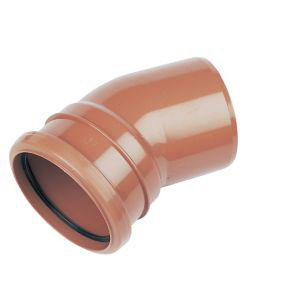
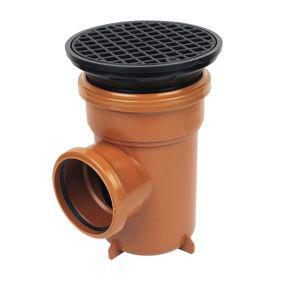
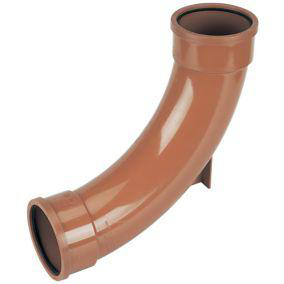
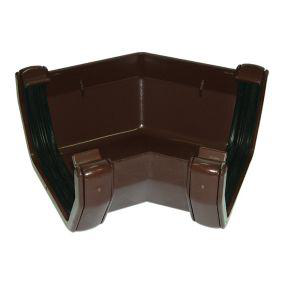
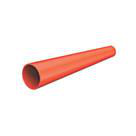
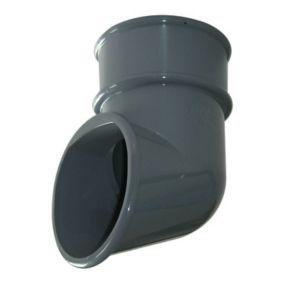
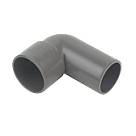
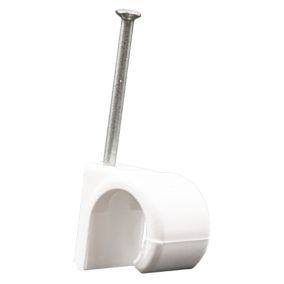
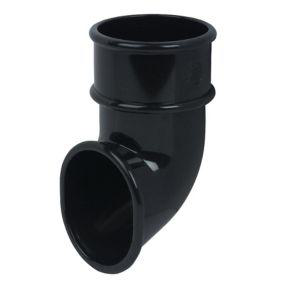
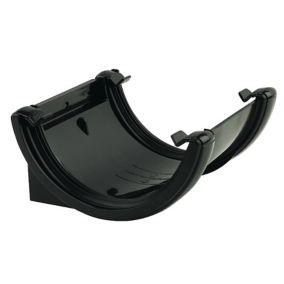
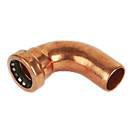
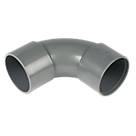
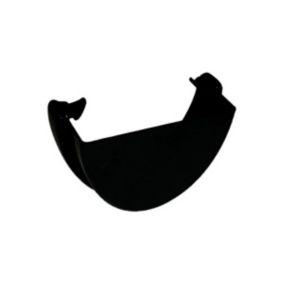
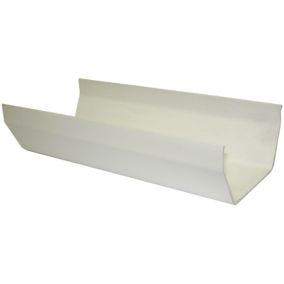
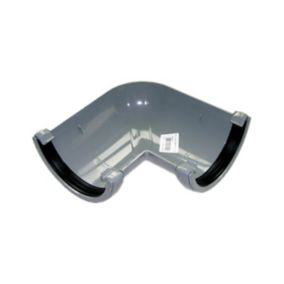
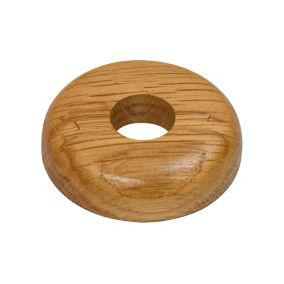
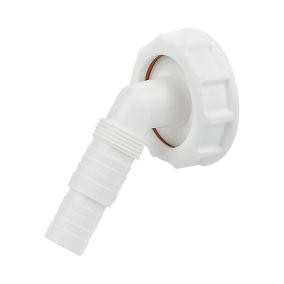
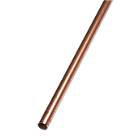
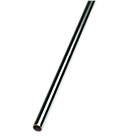
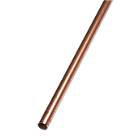
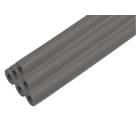
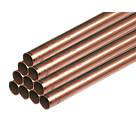
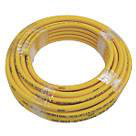
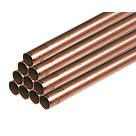
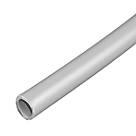
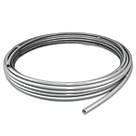
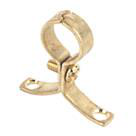
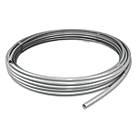
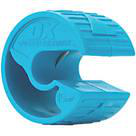
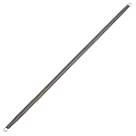

In [72]:
#
question = "pipe 15mm "
#
dense_vec = dense_model.encode(question)
#
query_vec, query_tokens = compute_vector(question,query_tokenizer,query_model)
query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]
#
results = return_results(query_indices,query_values,dense_vec)  
#
dense_match = []
sparse_match = []

scores = []
for result in results[0]:
   dense_match.append(result.id)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   scores.append(result.score)
imageids,productids = get_image_ids(dense_match,sparse_match)
#create documents
docs = create_docs(productids,scores)
#
# used returned product ids to get images
display_result(imageids)

In [46]:
#
question = "dewalt"
#
dense_vec = dense_model.encode(question)
#
query_vec, query_tokens = compute_vector(question,query_tokenizer,query_model)
query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]
#
results = return_results(query_indices,query_values,dense_vec)  
#
dense_match = []
sparse_match = []

scores = []
for result in results[0]:
   dense_match.append(result.id)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   scores.append(result.score)
#
imageids,productids = get_image_ids(dense_match,sparse_match)
#create documents
docs = create_docs(productids,scores)
# Perform Question Answering
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)
#
result = response['output_text']
print(result)

# used returned product ids to get images
display_result(imageids)

646
7172
552
7219
198
114
1313
913
7143
7128
723
1247
44289
6552
6680


NameError: name 'chain' is not defined

In [154]:
def return_results_hybrid(query_indices,query_values,dense_vec):
  results  = client.search_batch(
        collection_name=COLLECTION_NAME,
        requests=[
            models.SearchRequest(
                vector=models.NamedVector(
                    name="text-dense",
                    vector=dense_vec,
                ),
                limit=15,
            ),
            models.SearchRequest(
                vector=models.NamedSparseVector(
                    name="text-sparse",
                    vector=models.SparseVector(
                        indices=query_indices,
                        values=query_values,
                    ),
                ),
                limit=15,
            ),
        ],
    )
  return results

In [128]:
print(query_vec)

[ 1012  2102  2389 24903]


In [146]:
def hybrid_scale(dense, sparse_indices, sparse_values, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    
    query_indices_hybrid = sparse_indices
    query_values_hybrid = [v * (1 - alpha) for v in sparse_values]
    dense_vec = [v * alpha for v in dense]
    
    return dense_vec, query_indices_hybrid, query_values_hybrid

825
1234
526
111
3418
836
16
61
1
491
443
463
809
472
0



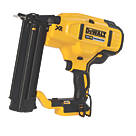
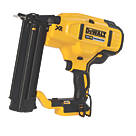
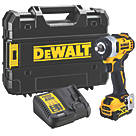
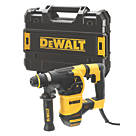
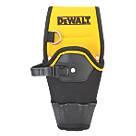
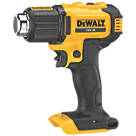
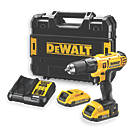
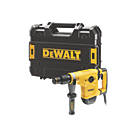
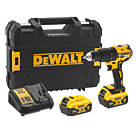
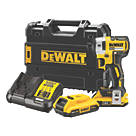
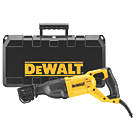
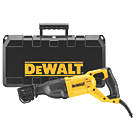
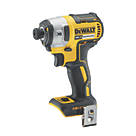
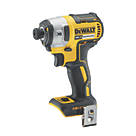
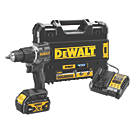
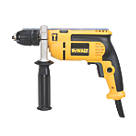
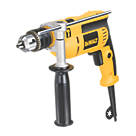
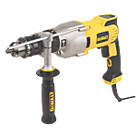
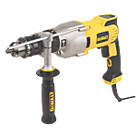
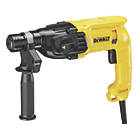
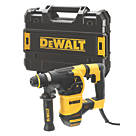
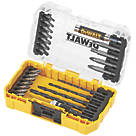
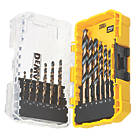
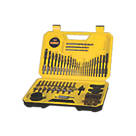
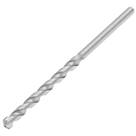
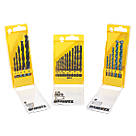
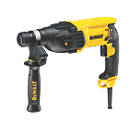
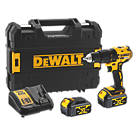
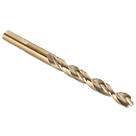
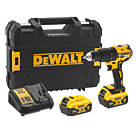

In [210]:
#
question = "dewalt drill"
#
dense_vec = dense_model.encode(question)
#
query_vec, query_tokens = compute_vector(question,query_tokenizer,query_model)
query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]

dense_vec_hybrid, query_indices_hybrid, query_values_hybrid = hybrid_scale(dense_vec, query_indices, query_values, alpha=0.05)
#
results = return_results_hybrid(query_indices_hybrid,query_values_hybrid,dense_vec_hybrid)  
#
dense_match = []
sparse_match = []

scores = []
for result in results[0]:
   dense_match.append(result.id)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   scores.append(result.score)
imageids,productids = get_image_ids(dense_match,sparse_match)
#create documents
docs = create_docs(productids,scores)
#
# used returned product ids to get images
display_result(imageids)